In [1]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import datetime
import matplotlib as plt

In [2]:
import sys
# setting path
sys.path.append('../')

from ruins.processing import drain_cap

In [3]:
# load primary data
data = xr.load_dataset('../data/hydro_krummh.nc').to_dataframe()
data.head()

,Prec_dissagg_1,Prec_dissagg_2,Prec_dissagg_3,Prec_dissagg_4,Prec_dissagg_5,Prec_dissagg_6,Prec_dissagg_7,Prec_dissagg_8,Prec_dissagg_9,Prec_dissagg_10,...,Prec_dissagg_77,Prec_dissagg_78,Prec_dissagg_79,Prec_dissagg_80,Prec,wl_Knock_Outer,wl_LW,wl_Knock_Inner,Knock_pump_obs,Q_Knock
date,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.1,NaN,-1325.000000,NaN,NaN,NaN
2011-01-01 01:00:00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.1,NaN,-1325.000000,NaN,NaN,NaN
2011-01-01 02:00:00,0.0,0.0,0.0,0.491553,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,-1319.090942,NaN,NaN,NaN
2011-01-01 03:00:00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.1,NaN,-1315.000000,NaN,NaN,NaN
2011-01-01 04:00:00,0.0,0.0,0.0,0.038447,0.0,0.240214,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.1,NaN,-1310.877563,NaN,NaN,NaN


{'2011-09': datetime.date(2011, 9, 3), '2011-12': datetime.date(2011, 12, 2), '2012-01': datetime.date(2011, 12, 29), '2013-11': datetime.date(2013, 11, 2), '2014-05': datetime.date(2014, 5, 6), '2015-11': datetime.date(2015, 11, 11), '2017-03': datetime.date(2017, 3, 15), '2017-09': datetime.date(2017, 9, 3), '2017-12': datetime.date(2017, 12, 4), '2018-01-03': datetime.date(2017, 12, 30), '2018-01-18': datetime.date(2018, 1, 13), '2020-02': datetime.date(2020, 2, 14)}


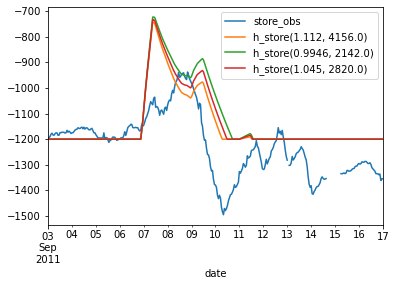

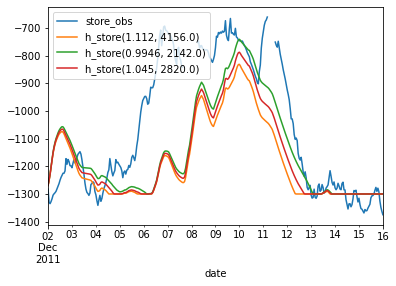

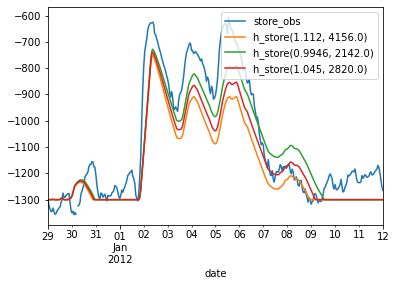

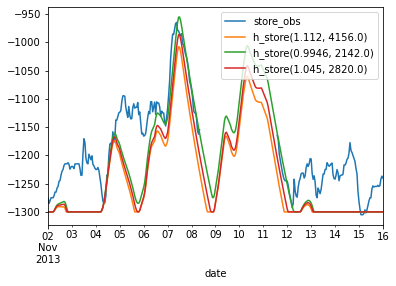

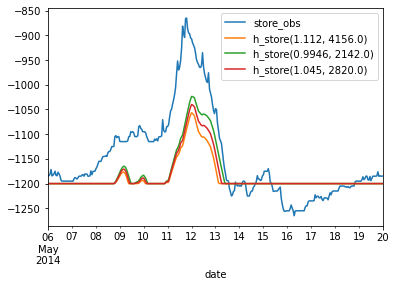

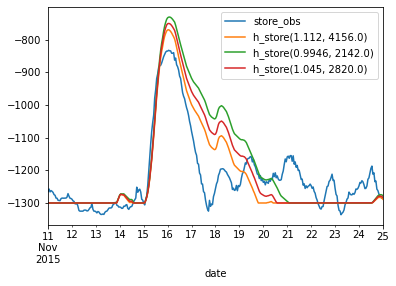

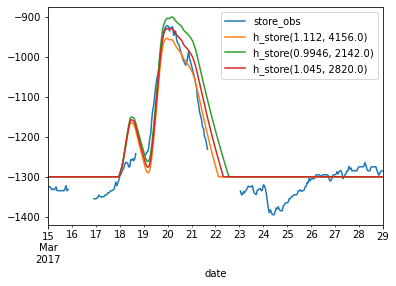

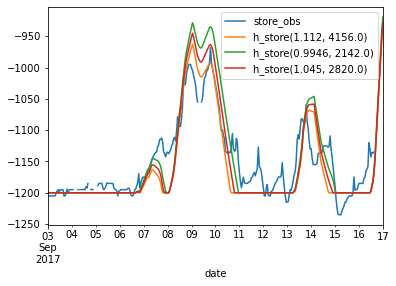

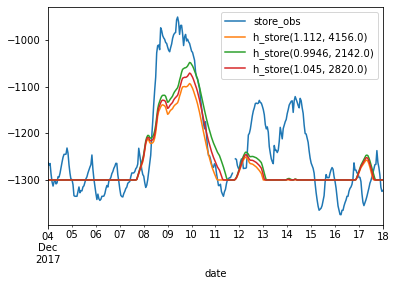

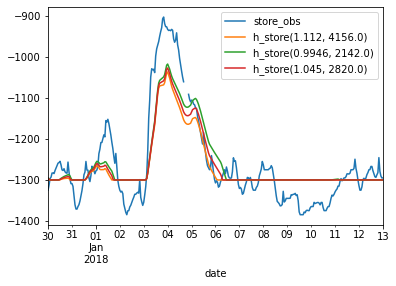

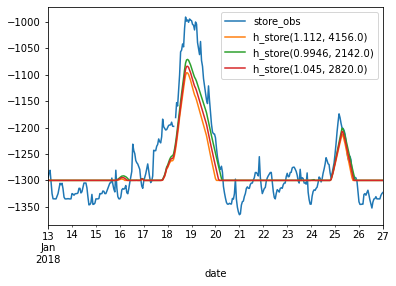

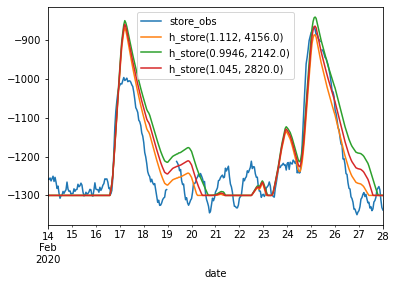

In [4]:
max_store = pd.DataFrame(columns = ['store_obs', 'store_sim'])

i=0
events = {
#    "2011-02":datetime.date(2011, 2, 10),  # missing water level data at Knock
#    "2011-08":datetime.date(2011, 8, 25),  # missing water level data at Knock
    "2011-09":datetime.date(2011, 9, 3),
    "2011-12":datetime.date(2011, 12, 2),
    "2012-01":datetime.date(2011, 12, 29),
    "2013-11":datetime.date(2013, 11, 2),
    "2014-05":datetime.date(2014, 5, 6),
    "2015-11":datetime.date(2015, 11, 11),
#    "2017-02":datetime.date(2017, 2, 19), # did not reach critical water level, manual identification
    "2017-03":datetime.date(2017, 3, 15),
    "2017-09":datetime.date(2017, 9, 3),
    "2017-12":datetime.date(2017, 12, 4),
    "2018-01-03":datetime.date(2017, 12, 30),
    "2018-01-18":datetime.date(2018, 1, 13),
    "2020-02":datetime.date(2020, 2, 14)
}

print(events)
Canal_area = 4
advance_pump = 0
for z in events:
    t1 = events[z]
    t2 = events[z]+datetime.timedelta(days=14)
    
    hourly_recharge = data["Prec"][t1:t2]
    days = (t2-t1).days
    hours = days*24 + 1

    tide = data['wl_Knock_Outer'][t1:t2]
    
    hourly_recharge = hourly_recharge.rolling("12h").mean() # smoothen rainfall signal to account for water redistribution within catchment
    
    maxdh = 4000     # set maximum pump gradient [mm]
    wig = tide*0     # no wind induced gradient -> this may be used to simulate a local flooding in a subcatchment
    canal_par = [(1.112 , 4156.), (0.9946, 2142.), (1.045 , 2820.)]
    x = pd.DataFrame.from_dict(
        {        
            'recharge' : hourly_recharge.fillna(0),
            'h_tide' : tide.fillna(100),
            'wig' : wig.fillna(0),
            'store_obs' : data['wl_LW'][t1:t2].fillna(-2200)
        }
    )
    if x.index[0].month in [10,11,12,1,2,3,4]:
        target = -1300
    else:
        target = -1200
    for z in canal_par:
        x['h_store'+str(z)], q_pump, h_min, flow_rec, pump_cost, store = drain_cap.storage_model(forcing_data = x,
                                                                                                 canal_par = z,
                                                                                                 v_store = 0,
                                                                                                 h_store_target = target,
                                                                                                 canal_area = Canal_area,
                                                                                                 h_forecast_pump = advance_pump,
                                                                                                 h_grad_pump_max = maxdh)#,
#                                                                                                         pump_par = pumpcap_fit)
        max_store.loc[str(i),:] = [max(x['store_obs']), max(x['h_store'+str(z)])]
        i+=1

    x = x[x>-2000]
    x.filter(regex = "store").plot()
#        result.loc[str(i),:] = [max(x['store']), sum(pump_cost), RCP, slr,prec_increase,event,str(z),Canal_area, advance_pump, raindissagg]

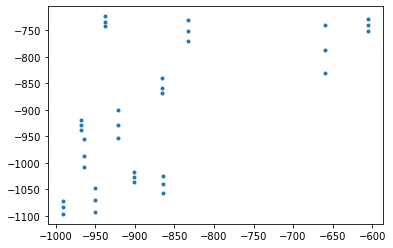

In [64]:

plt.pyplot.plot(max_store['store_obs'], max_store['store_sim'], linewidth = 0, marker = '.')

